In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import k_means, kmeans_plusplus, KMeans
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from random import randint
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

# Assignment 3 - Clustering

For this assignment you'll need to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

The modelling parts of this assignment are not very complex, the application of the clustering algorithms is very similar to the examples from class. This will require a little more manipulation of data, and building a little bit of structure around the models, that's where some of the challenge lies. 

## Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li> Do not use the targets from the dataset at all. 
    <li> Use as many clusters as you think is appropriate.
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li><b>So, to this point. You take the images, ditch their labels, and do clustering to group them. You don't know which cluster is which digit. You have to then label them, or look at each one and say, "looks like 7s", then assign that group a label of 7. </b>
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. Each digit should be a new generation of data.</b>
</ul>

## Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Within your file, create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits. The function should be callable like this, if I wanted to print the number 218201

~~~
writeNumber(218201)
~~~

This would produce something that looks, somewhat, like this:

![Writing Example](example.png "Writing Example" )

The exact appearance of the generated writing can vary, it likely won't be as well defined as this picture. As long as I can read it as a number, it is fine. 

Hint: the number of clusters may vary. 

## Grading
<ul>
<li> 70% - Code works. This is mostly a yes/no thing, if it doesn't work I'll try to see if it was a small or large issue in the code, but it largely works or it doesn't. 
<li> 20% - Numbers appearance. Is the writing OK? I'm not going to be overly picky, if they are reasonably legible, that is fine. 
<li> 10% - Code legibility. Is a quick read over of the code clear? Sections, comments, etc... 
</ul>

In [2]:
#Look at an image
def showDigit(digit, label, size=20):
    some_digit = digit
    #turn array into the correct shape
    some_digit_image = np.array(some_digit).reshape(size, size)
    #imshow displays an array like an image
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.title(label)
    plt.axis("off")
    plt.show()

In [3]:
#Display multiple digits
def showDigits(digits, labels, indexes, size=28):
    #Make a grid that is the right size
    pics = len(indexes)
    cols = 8
    rows = math.ceil(pics/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14,6))
    plt.axis("off")

    #loop through the list of indexes, grab images and labels, plot in the "next" spot. 
    for i in range(0, pics):
        n = indexes[i]
        some_digit = digits[n:n+1]
        some_digit_image = np.array(some_digit).reshape(size, size)
        ax = axes[i//cols, i%cols]
        ax.axis("off")
        ax.imshow(some_digit_image, cmap=mpl.cm.binary)
        #ax.set_title('Ind: {} - Lbl: {}'.format(indexes[i], labels[n]))
    plt.tight_layout()
    plt.axis("off")
    plt.show()

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [4]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
#mnist = mnist[0:15000]
X = mnist["data"]
print(X.shape)

(70000, 784)


## Cluster 

We need to break the data into clusters first... 

Performs dimensionality reduction using PCA and KMeans clustering on a dataset X, and then displays the resulting cluster centers as digit images using the showDigits() function.

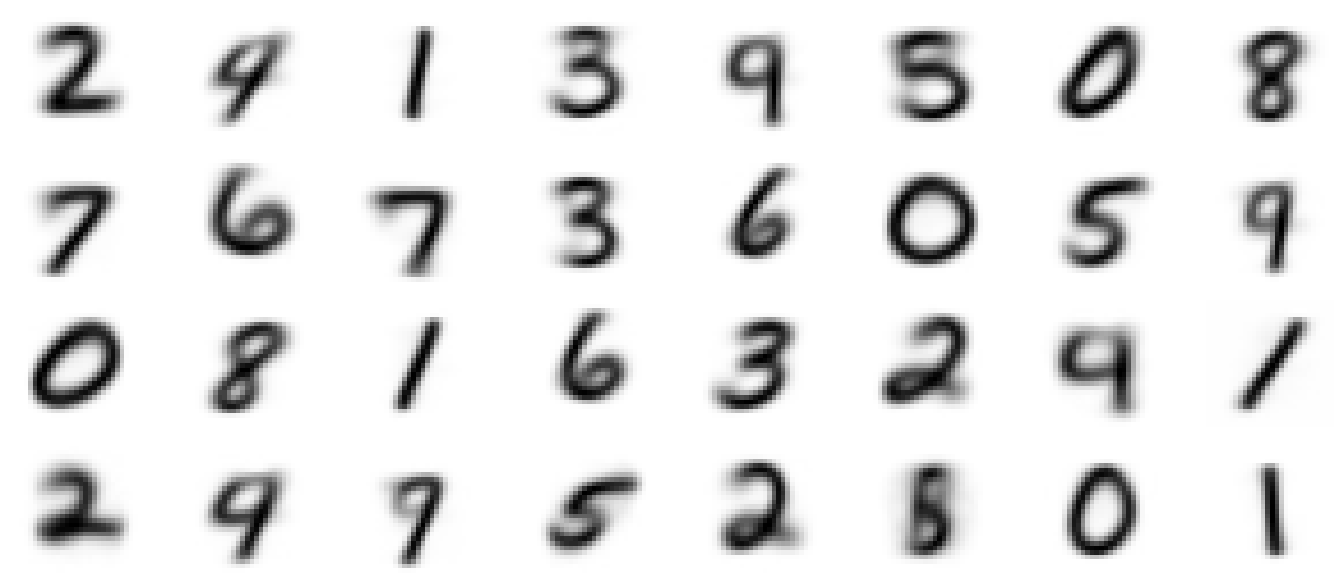

In [5]:
# perform PCA transformation
pca = PCA(n_components=0.99)
X_transformed = pca.fit_transform(X)

# perform KMeans clustering
kmeans = KMeans(n_clusters=32, init="k-means++", random_state=12)
clusters = kmeans.fit_predict(X_transformed)

# display cluster centers using showDigits()
centers = pca.inverse_transform(kmeans.cluster_centers_)
indexes = np.array(range(0,32))
showDigits(digits=centers, labels=[" ", " ", " ", " ", " ", " ", " ", " ", " ", " "], indexes=indexes, size=28)


## Visually Match the Clusters

In [6]:
df = pd.DataFrame(X)
df["labels"] = kmeans.labels_
df["labels"].value_counts()

29    3130
26    3049
4     2999
15    2940
25    2680
19    2527
2     2509
7     2493
11    2414
12    2393
18    2352
17    2344
1     2332
10    2298
31    2221
8     2219
5     2205
3     2189
20    2187
14    2151
27    2078
22    2045
16    1843
13    1737
28    1728
30    1715
21    1655
0     1641
9     1607
23    1536
6     1457
24    1326
Name: labels, dtype: int64

Maps the label values of a dataset to a new set of values defined by a dictionary num_eyepic, and then counts the number of occurrences of each label value in the dataset.

In [7]:
num_eyepic = {0:2, 1:4, 2:1, 3:3, 4:9, 5:5, 6:0, 7:8, 
             8:7, 9:6, 10:7, 11:3, 12:6, 13:0, 14:5, 15:9, 
             16:0, 17:8, 18:1, 19:6, 20:3, 21:2, 22:9, 23:1, 
             24:2, 25:9, 26:9, 27:5, 28:2, 29:8, 30:0, 31:1}
df["labels"] = df["labels"].map(num_eyepic)
df["labels"].value_counts()

9    13713
1     8618
8     7967
3     6790
0     6752
6     6527
5     6434
2     6350
7     4517
4     2332
Name: labels, dtype: int64

Selects a random set of 32 samples from each of 10 label categories in a dataset, then displays the selected samples as digit images using the showDigits() function.

0


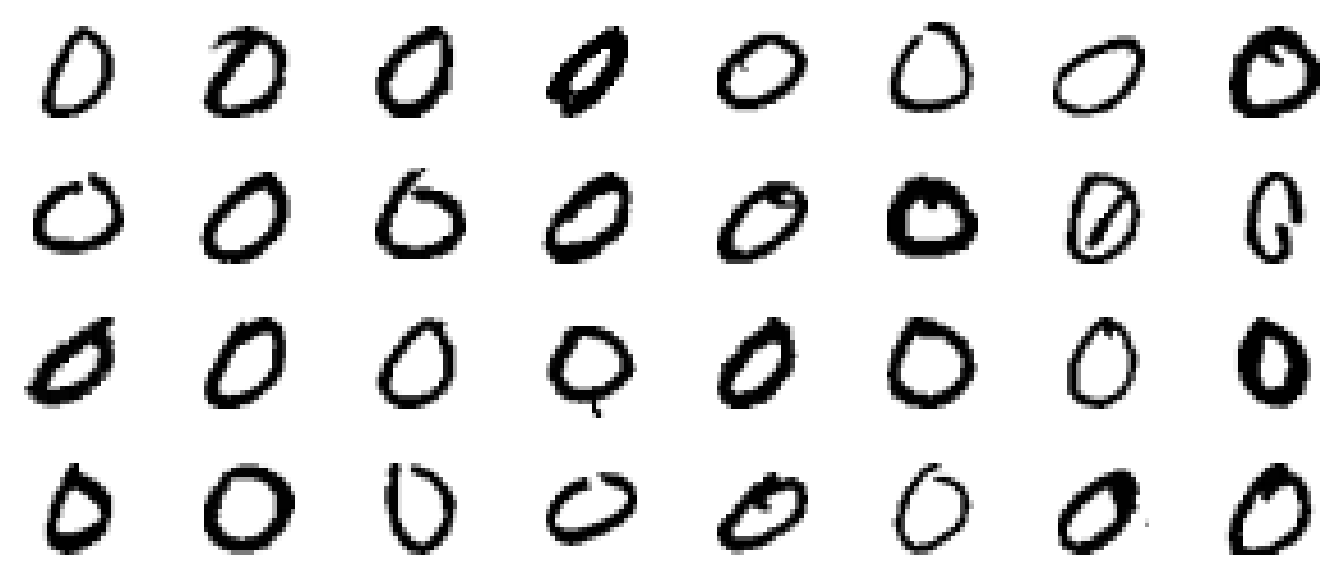

1


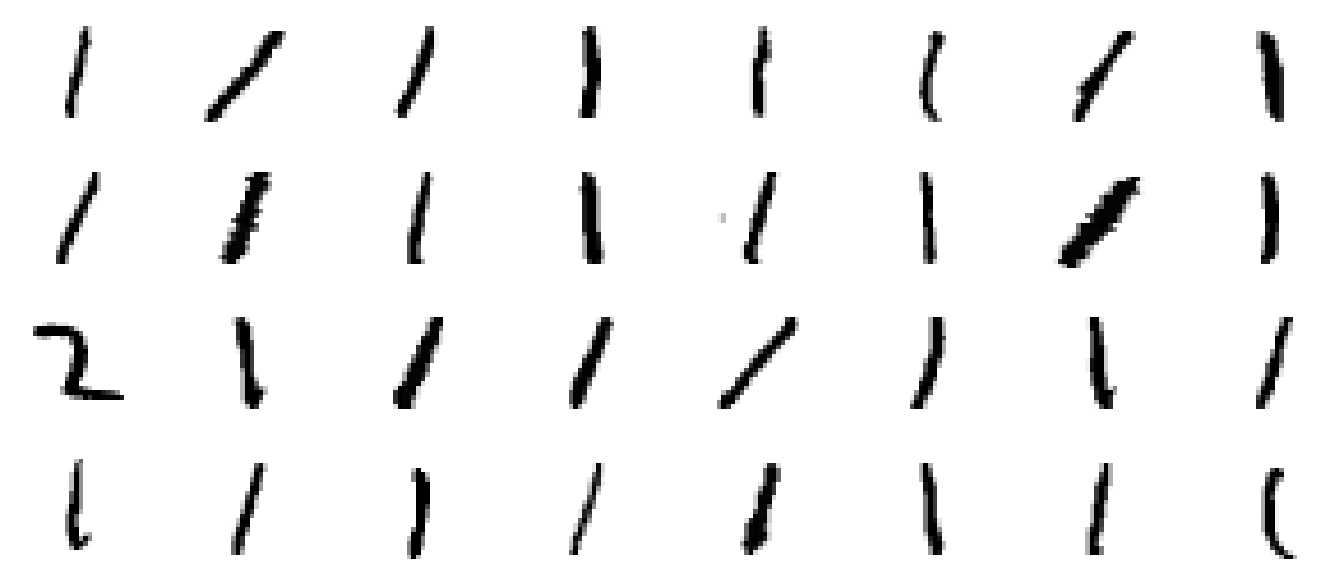

2


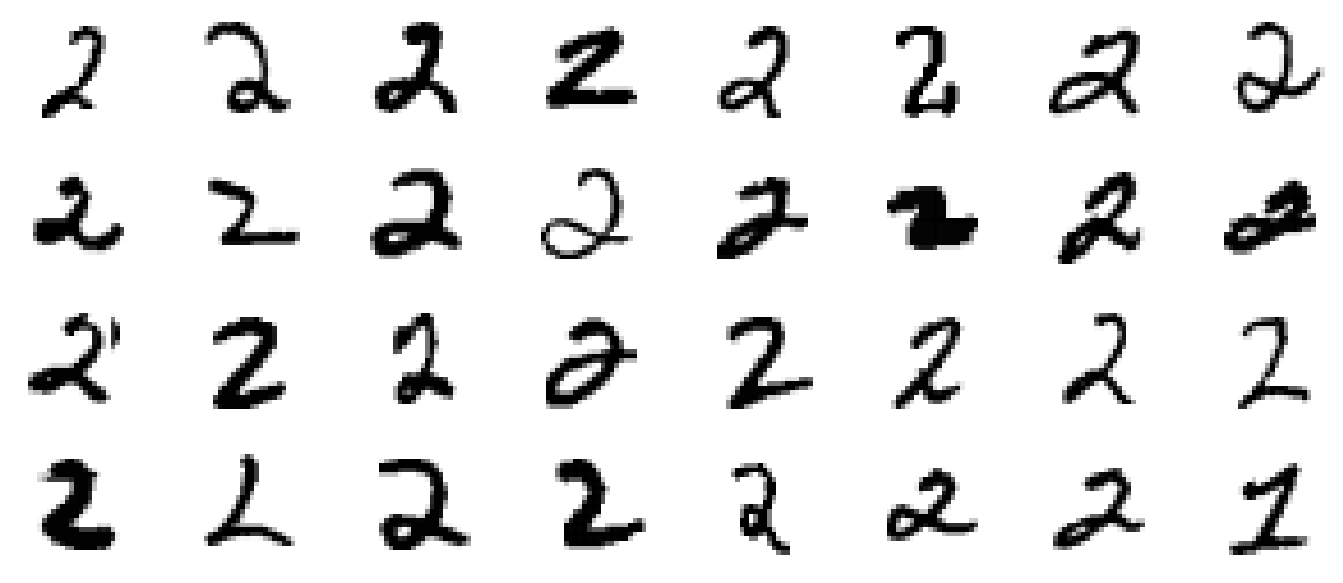

3


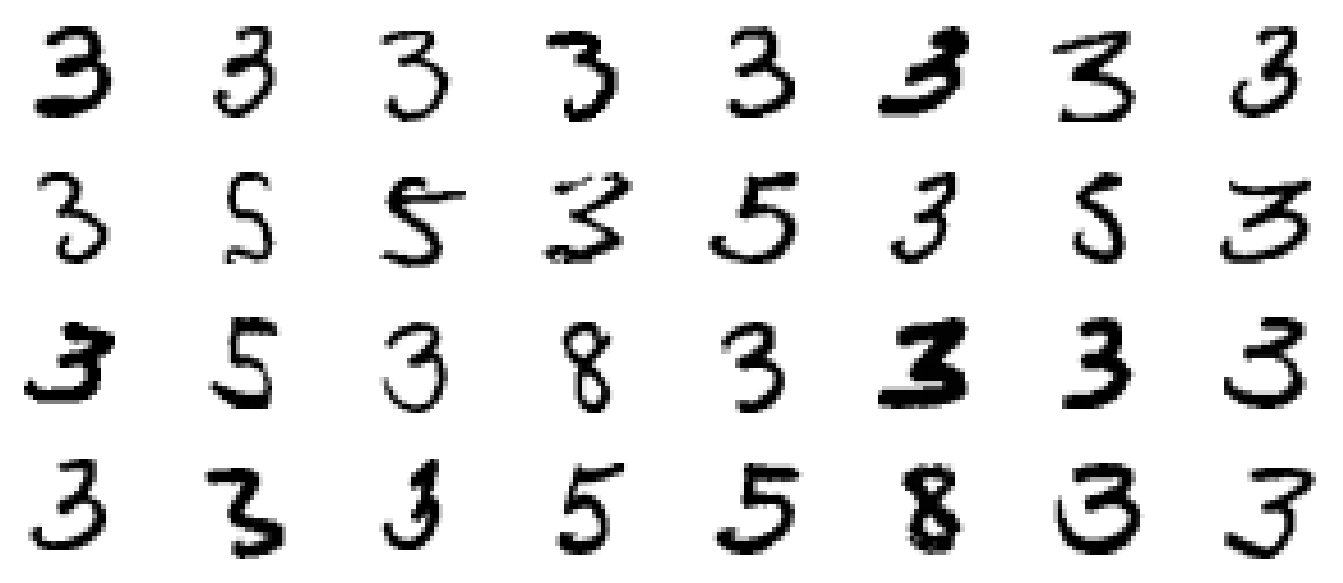

4


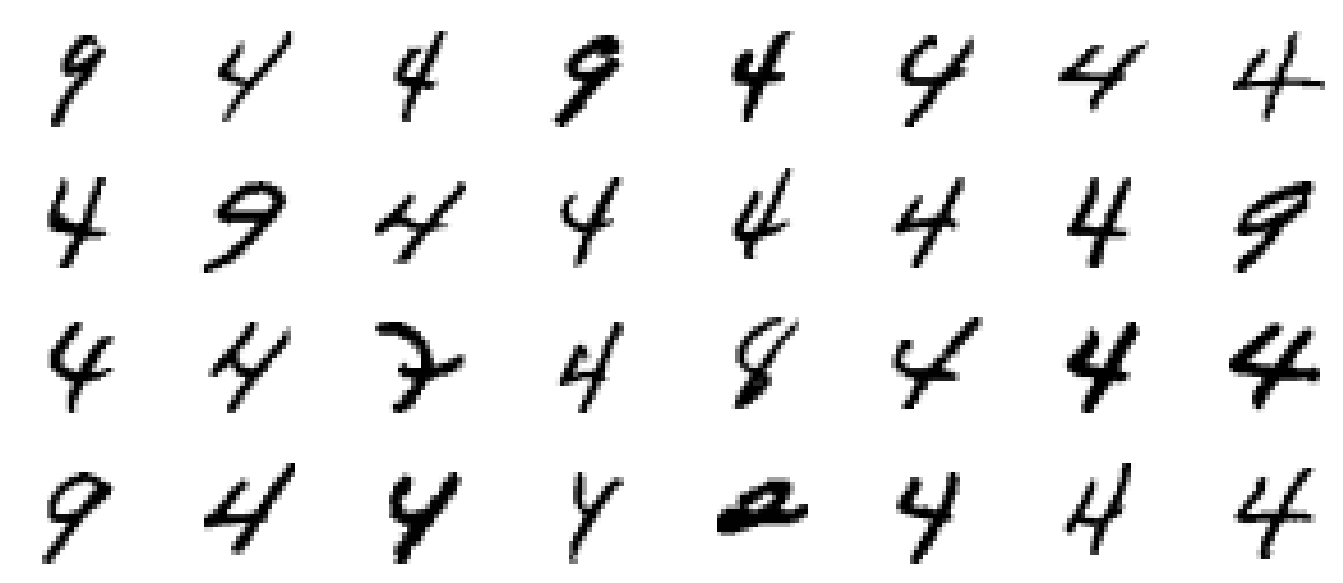

5


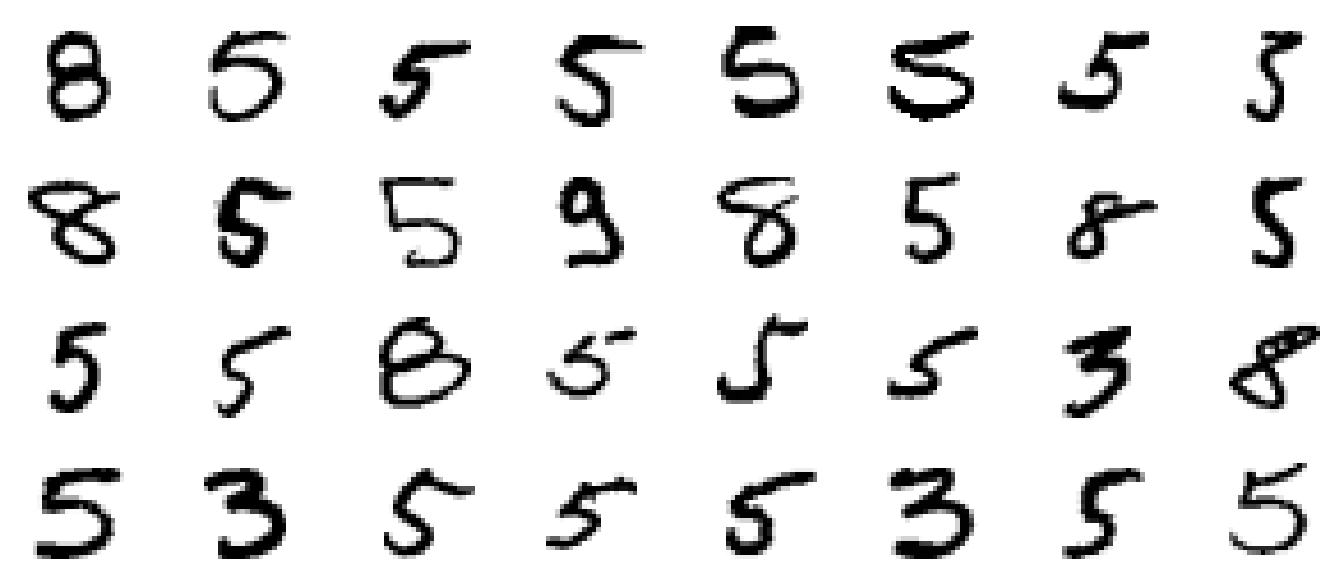

6


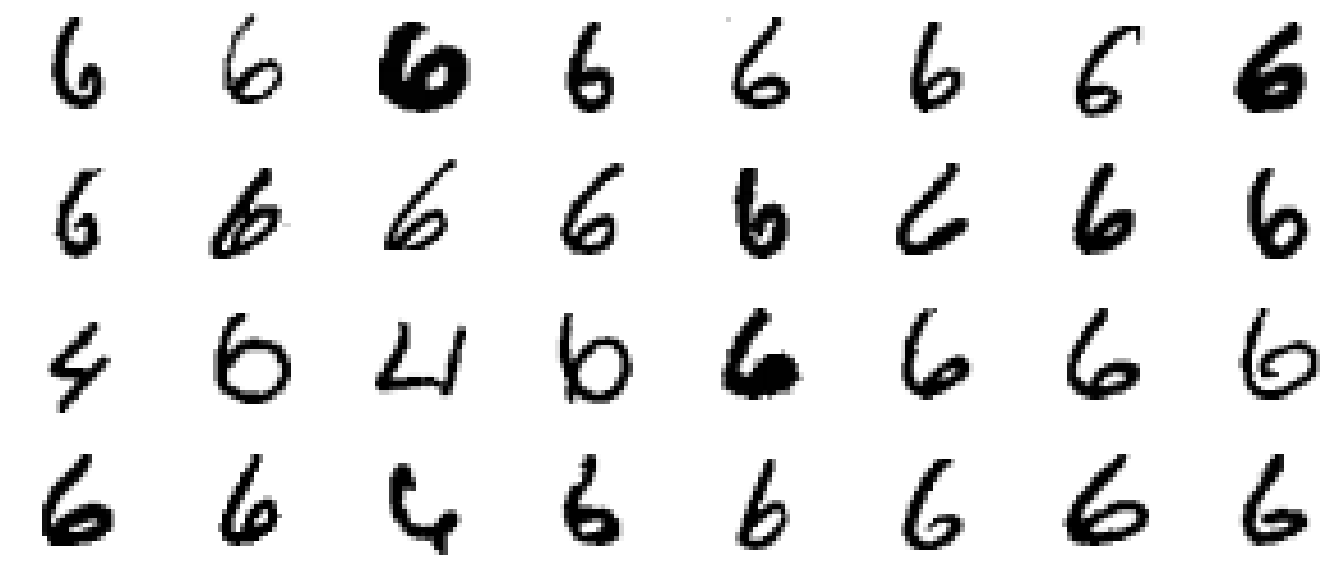

7


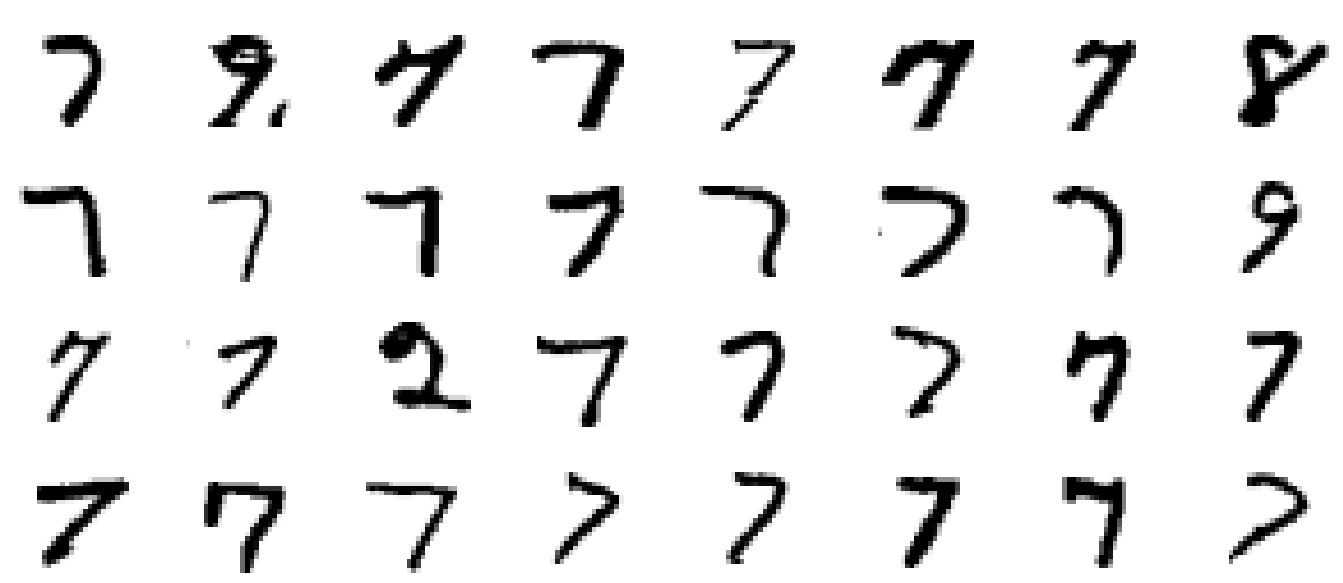

8


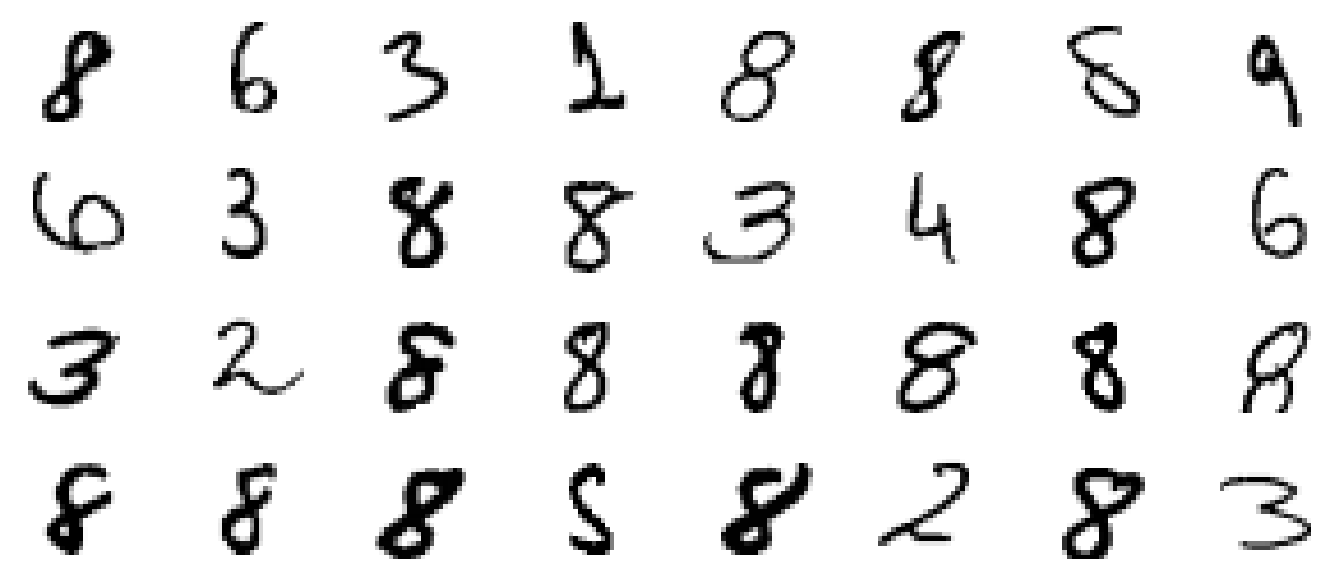

9


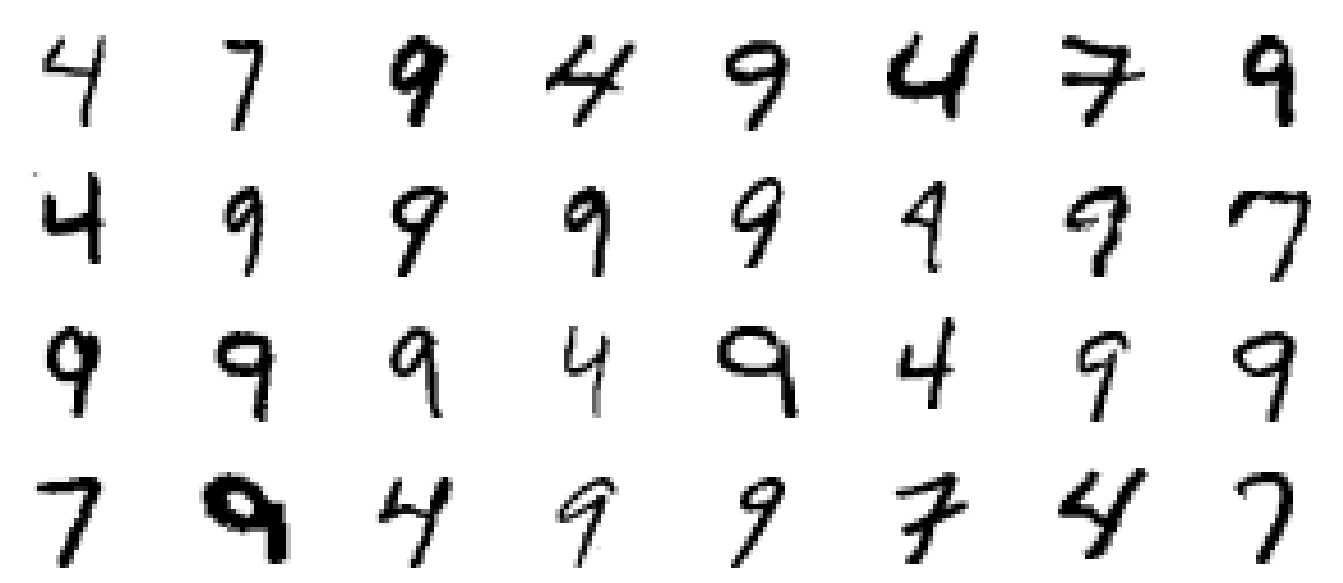

In [8]:
for i in range(10):
    samp_ind = df[df["labels"] == i].index.values
    rows = df.loc[samp_ind,:].sample(32)
    print_ind = rows.index.values
    y_tmp = np.full(10, i)
    ind_tmp = np.array(range(0,10))
    #print(print_ind)
    print(i)
    showDigits(df.drop(columns={"labels"}).to_numpy(), y_tmp, print_ind)

## Generator by Gaussian Mixture Model 

In [9]:
np.array(df[df["labels"]==1].drop(columns={"labels"})).shape

(8618, 784)

Trains a set of 10 Gaussian Mixture Models (GMMs) on a dataset df where each model corresponds to a label category from 0 to 9. The code checks if each GMM has converged during training and stores the models in a list generators.

In [10]:
generators = [GaussianMixture(covariance_type='full', random_state=0).fit(np.array(df[df["labels"] == i].drop(columns={"labels"}))) for i in range(10)]
print("Converged:", [gmm.converged_ for gmm in generators])


C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


Converged: [True, True, True, True, True, True, True, True, True, True]


Generates 16 samples of digit 4 using the pre-trained GMM for digit 8 and displays the resulting samples as digit images using imshow() and subplot().

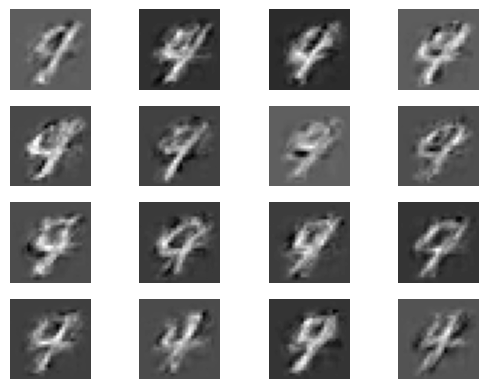

In [11]:
n_samples = 16
digit = 4
data = generators[digit].sample(n_samples)[0]
for i in range(n_samples):
    plt.subplot(4, 4, i+1)
    plt.imshow(data[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()


## Test numbers


Displays a set of 100 randomly generated images for each digit in a given number, with the images displayed horizontally.

In [12]:
def display_number_samples(number):
    num_str = str(number)
    n_digits = len(num_str)
    
    fig, axes = plt.subplots(1, n_digits, figsize=(14, 6))
    
    for i in range(n_digits):
        digit = int(num_str[i])
        samples = generators[digit].sample(100)
        sample = samples[0][randint(0, 99)]
        img = np.array(sample).reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    plt.show()

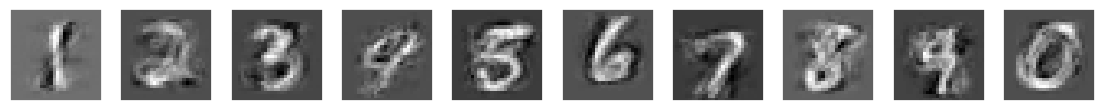

In [13]:
display_number_samples(1234567890)
